In [206]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib import dates as mlp_dates
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [207]:
first_data = pd.read_csv('rainfall_data.csv')

In [208]:
first_data.isna().sum()

YEAR              0
MONTH             0
DAY               0
RAINFALL          0
TMAX              4
TMIN              4
TMEAN             4
WIND_SPEED        4
WIND_DIRECTION    4
RH                4
dtype: int64

In [209]:
first_data['RAINFALL'] = pd.to_numeric(first_data['RAINFALL'], errors='coerce')

# Split data into training and testing sets
train_size = int(len(first_data) * 0.8)
train_data = first_data.iloc[:train_size]
test_data = first_data.iloc[train_size:]

tmax_mean = train_data['TMAX'].mean()
tmin_mean = train_data['TMIN'].mean()
tmean_mean = train_data['TMEAN'].mean()
wind_speed_mean = train_data['WIND_SPEED'].mean()
wind_direct_mean = train_data['WIND_DIRECTION'].mean()
rh_mean = train_data['RH'].mean()

data = first_data.fillna(value={'RAINFALL': 0, 'TMAX': tmax_mean, 'TMIN': tmin_mean, 'TMEAN': tmean_mean, 'WIND_SPEED': wind_speed_mean, 'WIND_DIRECTION': wind_direct_mean, 'RH': rh_mean}).copy()


In [210]:

data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], format='%d-%b-%y')
data.set_index('Date', inplace=True)
data.drop(columns=['YEAR', 'DAY', 'MONTH'], inplace=True)

In [211]:
data['RAINFALL'].max()

455.0

In [212]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 12
X_train, y_train = create_sequences(scaled_data[:train_size], seq_length)
X_test, y_test = create_sequences(scaled_data[train_size:], seq_length)
# model architecture to output a single value
input_shape = X_train.shape[1:]
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dropout(0.25))
model.add(Dense(1)) 

# Compile the LSTM model
adam = Adam(learning_rate=0.0005)
model.compile( loss='mean_squared_error', optimizer='adam', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=50, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1)
mcp = ModelCheckpoint(filepath='model_weights.weights.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=32, callbacks=[es, rlr, mcp, tb], validation_split=0.25, batch_size=32, verbose=4)



Epoch 1/32

Epoch 1: val_loss improved from inf to 0.96187, saving model to model_weights.weights.h5
Epoch 2/32

Epoch 2: val_loss improved from 0.96187 to 0.92473, saving model to model_weights.weights.h5
Epoch 3/32

Epoch 3: val_loss did not improve from 0.92473
Epoch 4/32

Epoch 4: val_loss did not improve from 0.92473
Epoch 5/32

Epoch 5: val_loss did not improve from 0.92473
Epoch 6/32

Epoch 6: val_loss did not improve from 0.92473
Epoch 7/32

Epoch 7: val_loss improved from 0.92473 to 0.91956, saving model to model_weights.weights.h5
Epoch 8/32

Epoch 8: val_loss did not improve from 0.91956
Epoch 9/32

Epoch 9: val_loss did not improve from 0.91956
Epoch 10/32

Epoch 10: val_loss did not improve from 0.91956
Epoch 11/32

Epoch 11: val_loss did not improve from 0.91956
Epoch 12/32

Epoch 12: val_loss did not improve from 0.91956
Epoch 13/32

Epoch 13: val_loss did not improve from 0.91956
Epoch 14/32

Epoch 14: val_loss did not improve from 0.91956
Epoch 15/32

Epoch 15: val_los

In [213]:
import math
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3756
Train Score: 0.55 MSE (0.74 RMSE)
Test Score: 0.78 MSE (0.88 RMSE)


237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


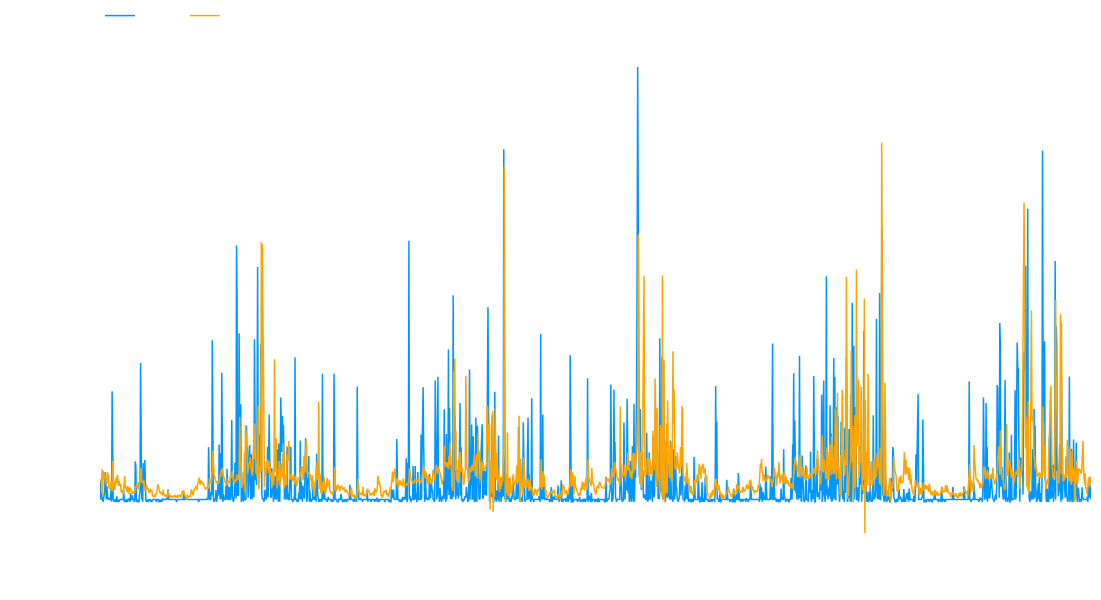

In [214]:
# PREDICTION
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
# SCALING FOR PREDICTION
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, X_test[:, -1, 1:]), axis=1))[:, 0]

# SCALING FOR ACTUAL
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

config = {'displaylogo': False, 'displayModeBar': True}
actual_trace = go.Scatter(
    x=list(range(len(y_test_inv))),
    y=y_test_inv,
    mode='lines',
    line=dict(width=1.5, color='#0096FF'),
    name='Actual',
    hovertemplate='%{y:.2f}',
)

predicted_trace = go.Scatter(
    x=list(range(len(test_predictions))),
    y=test_predictions,
    mode='lines',
    line=dict(width=1.5, color='orange'),
    name='Forecasted',
    hovertemplate='%{y:.2f}',
)

fig = go.Figure()
fig.add_trace(actual_trace)
fig.add_trace(predicted_trace)

fig.update_layout(
        title=dict(
        text='Test Set: Actual vs Predicted',
        x=0.55,
        xanchor='center'
    ),
     xaxis=dict(
        title='Test Set',
        titlefont=dict(size=14, color='white'),
        tickformat='%b %d, %Y',
        tickangle=0,
        tickfont=dict(size=12, color='white')
    ),
    yaxis=dict(
        title='Rainfall (mm)',
        titlefont=dict(size=15, color='white'),
        tickfont=dict(size=12, color='white')
    ),
    margin=dict(t=0, l=100, b=10, r=10),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family='Arial',
        size=14,
        color='white'
    ),
    legend=dict(
        orientation='h',
        yanchor='top',
        y=1.08,
        xanchor='left',
        x=0
    ),
    hovermode='x unified',
    hoverlabel=dict(
        bgcolor='rgba(0, 0, 0, 0.7)',  
        font=dict(size=15, family='Helvetica', color='white')
    ),
    width = 990,
    height = 600,
    modebar_remove=['zoom', 'lasso','select2d','lasso2d','resetScale2d']
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='rgba(255, 255, 255, 0.3)', showspikes = True, spikecolor="white", spikethickness = 0.7, spikedash='solid', )
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgba(255, 255, 255, 0.3)')

html_str = pio.to_html(fig, config=config)
with open('rainfall_test_set.html', 'w', encoding='utf-8') as f:
    f.write(html_str)

# Display the plot (if running in an interactive environment)
fig.show()

In [215]:
model.save("Model_rainfall.h5")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


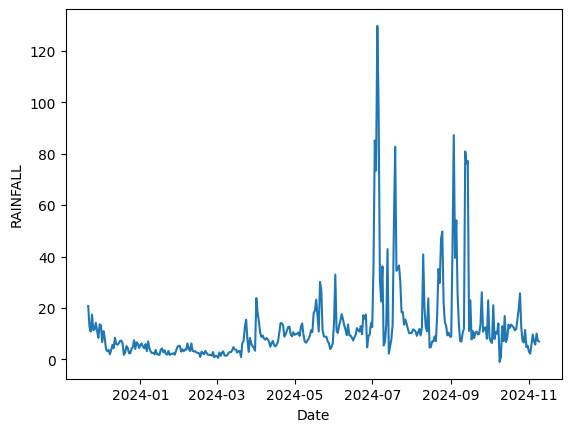

In [216]:
train_dates = list(data.index)
n_past = 10
n_days_for_prediction= 355
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='d').tolist()
prediction = model.predict(X_test[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
prediction_copies = np.repeat(prediction, data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'RAINFALL':y_pred_future})
plt = sns.lineplot(data=df_forecast, x='Date', y='RAINFALL')
df_forecast.set_index('Date', inplace=True)


In [217]:
import seaborn as sns
import matplotlib.pyplot as plt

# For the past data
original = data[['RAINFALL']]
original = original.loc[(original.index >= original.index[-7]) & (original.index <= original.index[-1])]

# For the forecasted data plot
last_known_date = original.index[-1]
start_date = last_known_date + pd.Timedelta(days=-6)
forecast_end_date = start_date + pd.Timedelta(days=40)
forecast_dates = pd.date_range(start=start_date, end=forecast_end_date)
forecast_values = df_forecast.loc[forecast_dates, 'RAINFALL']

# Connect the past data to the forecasted data
last_known_value = original['RAINFALL'].iloc[-1]

config = {'displaylogo': False}

past_trace = go.Scatter(
    x=original.index, 
    y=original['RAINFALL'],
    mode='markers+lines',
    marker=dict(color='#7CFC00', size=5),
    line=dict(width=3),
    name='Actual',
    hovertemplate='%{y:.2f}',  
)

forecast_trace = go.Scatter(
    x=forecast_dates,
    y=forecast_values,
    mode='markers+lines',
    marker=dict(color='orange', size=5),
    line=dict(width=3),
    name='Forecasted',
    hovertemplate='%{y:.2f}',
)

fig = go.Figure()
fig.add_trace(past_trace)
fig.add_trace(forecast_trace)

fig.update_layout(
    xaxis=dict(
        title='DATE',
        titlefont=dict(size=14, color='white'),
        tickformat='%b %d, %Y',
        tickangle=0,
        tickfont=dict(size=12, color='white')
    ),
    yaxis=dict(
        title='RAINFALL',
        titlefont=dict(size=15, color='white'),
        tickfont=dict(size=12, color='white')
    ),
    margin=dict(t=0, l=100, b=10, r=10),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family='Arial',
        size=14,
        color='white'
    ),
    legend=dict(
        orientation='h',
        yanchor='top',
        y=1.08,
        xanchor='left',
        x=0
    ),
    hovermode='x unified',
    hoverlabel=dict(
        bgcolor='rgba(0, 0, 0, 0.7)',  
        font=dict(size=15, family='Helvetica', color='white')
    ),
    width = 990,
    height = 600,
    modebar_remove=['zoom', 'lasso','select2d','lasso2d','resetScale2d']
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='rgba(255, 255, 255, 0.3)', showspikes = True, spikecolor="white", spikethickness = 0.7, spikedash='solid', )
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='rgba(255, 255, 255, 0.3)')

In [218]:
fore_rain_error = abs(y_test_inv - test_predictions)
fore_percentage_rain_error = fore_rain_error / (abs(y_test_inv) + abs(test_predictions))
fore_rain_smape = 100 * np.mean(fore_percentage_rain_error)
fore_rain_smape = round(fore_rain_smape,2)
fore_rain_smape

78.11